# Baseline Models

In this notebook, we will construct a series of models based on features that were extracted from 12-lead ECG data (i.e., not use the actual waveforms). 

These models were serve as a baseline for additional models to build off of and improve from.

In [ ]:
!pip install llvmlite --ignore-installed
!pip install 'pycaret'
!pip install scikit-learn

In [ ]:
!pip install scipy

## Load extracted features

Features have already been extracted in a separate script and saved to disk (long compute time).  

For this analysis, we will just use CV, so we can combine the validation and training data.


In [62]:
import h5py
import pandas as pd

def get_split(X_name, Y_name):
    hf = h5py.File('data/model_data/feature_data.h5', 'r')
    X = hf.get(X_name)
    Y = hf.get(Y_name)
    Y = pd.DataFrame(Y).to_numpy()
    columns = hf.get("columns")
    columns = [col.decode('utf-8') for col in hf["columns"][:]]
    X = pd.DataFrame(data=X, columns = columns)
    hf.close()
    return X, Y

X_train, Y_train = get_split("X_train", "Y_train")
X_val, Y_val = get_split("X_val", "Y_val")
X_test, Y_test = get_split("X_test", "Y_test")

In [63]:
import numpy as np

# Combine train and validation sets
X_train = pd.concat([X_train, X_val])
Y_train = np.concatenate([Y_train, Y_val])

## Initial Feature Selection

Many columns that are primarily missing data or little/no variance.  Cut back on initial features here

In [64]:
from sklearn.feature_selection import VarianceThreshold

# Before setting a variance threshold, will standardize variables to 
# put them all on a similar playing field
normalized_df = X_train / X_train.mean()
vt = VarianceThreshold(threshold=.003)
_ = vt.fit(normalized_df)
mask = vt.get_support()
normalized_df_sel = normalized_df.loc[:, mask]
normalized_df_sel = normalized_df_sel[normalized_df_sel.columns[normalized_df_sel.isnull().mean() < 0.4]]
normalized_df_sel.shape

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


(17439, 64)

In [65]:
train = X_train[normalized_df_sel.columns]
train = pd.DataFrame(train)

train['target'] = Y_train
train
test = X_test[normalized_df_sel.columns]
test['target'] = Y_test

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [69]:
for i in range(test.shape[1]):
    test.iloc[:, i] = test.iloc[:, i].replace([np.inf, -np.inf], np.nan)

# Downsampling

For this analysis, we will perform downsampling on the majority class to help with both compute and the large class imbalance

In [66]:
print(train.shape)
print(train['target'].value_counts())

(17439, 65)
0    13521
1     3918
Name: target, dtype: int64


In [67]:
# Get indices of majority class
class_0_idx = train[train.target == 0].index

# Sample from majority class
n_samples = 6000
sampled_class_0_idx = np.random.choice(class_0_idx, size=n_samples, replace=False)

# Samples from minority class
class_1_idx = train[train.target == 1].index

# Merge the selected samples
idx_sampled = np.concatenate([sampled_class_0_idx, class_1_idx])
idx_sampled.sort()

# Filter the training data
train = train.iloc[idx_sampled]

print(len(sampled_class_0_idx))
print(len(class_1_idx))
print(len(idx_sampled))
print(train.shape)

6000
3918
9918
(9918, 65)


In [70]:
from pycaret.classification import *

exp_name = setup(
    data = train,
    target = 'target',
    fold_strategy='stratifiedkfold',
    test_data=test
)

,Description,Value
0,Session id,1279
1,Target,target
2,Target type,Binary
3,Original data shape,"(15392, 65)"
4,Transformed data shape,"(31174, 65)"
5,Transformed train set shape,"(22265, 65)"
6,Transformed test set shape,"(8909, 65)"
7,Numeric features,64
8,Rows with missing values,28.0%
9,Preprocess,True


In [71]:
best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7476,0.7584,0.4528,0.7384,0.5595,0.3969,0.4212,1.7800
gbc,Gradient Boosting Classifier,0.7416,0.7558,0.4599,0.7142,0.5577,0.3873,0.4071,7.1620
lightgbm,Light Gradient Boosting Machine,0.7320,0.7535,0.4704,0.6792,0.5543,0.3719,0.3857,0.9780
ada,Ada Boost Classifier,0.7149,0.7338,0.4724,0.6338,0.5404,0.3402,0.3485,1.3260
et,Extra Trees Classifier,0.6976,0.7055,0.2587,0.7049,0.3752,0.2301,0.2810,1.2840
lda,Linear Discriminant Analysis,0.6922,0.6832,0.2777,0.6608,0.3882,0.2272,0.2661,0.5060
ridge,Ridge Classifier,0.6688,0.0000,0.1673,0.6323,0.2629,0.1343,0.1845,0.4360
lr,Logistic Regression,0.6661,0.6408,0.1911,0.5986,0.2880,0.1401,0.1799,1.6020
dummy,Dummy Classifier,0.6448,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500
dt,Decision Tree Classifier,0.6319,0.6007,0.4932,0.4824,0.4873,0.2004,0.2006,0.6840


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [74]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7301,0.7802,0.4185,0.7013,0.5241,0.3522,0.3750
1,0.7144,0.7581,0.3932,0.6660,0.4944,0.3134,0.3345
2,0.7140,0.7249,0.4058,0.6578,0.5020,0.3168,0.3350
3,0.7306,0.7467,0.4753,0.6702,0.5562,0.3707,0.3820
4,0.7616,0.7603,0.4766,0.7632,0.5868,0.4315,0.4551
5,0.7601,0.7683,0.5076,0.7344,0.6003,0.4370,0.4522
6,0.7345,0.7643,0.3582,0.7711,0.4892,0.3408,0.3865
7,0.7502,0.7830,0.5019,0.7102,0.5881,0.4164,0.4293
8,0.7282,0.7501,0.4867,0.6592,0.5600,0.3698,0.3787


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [88]:
tuned_gbc = tune_model(gbc, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7238,0.7833,0.3742,0.7115,0.4905,0.3253,0.3569
1,0.7319,0.7662,0.4083,0.7146,0.5197,0.3524,0.3790
2,0.7113,0.6979,0.3401,0.6897,0.4555,0.2887,0.3221
3,0.7346,0.7608,0.3780,0.7513,0.5029,0.3479,0.3861
4,0.7485,0.7737,0.3906,0.7984,0.5246,0.3799,0.4248
5,0.7821,0.8088,0.4544,0.8692,0.5968,0.4669,0.5131
6,0.7269,0.7560,0.2873,0.8346,0.4275,0.3003,0.3740
7,0.7457,0.7849,0.4210,0.7551,0.5406,0.3838,0.4152
8,0.7305,0.7511,0.4260,0.6977,0.5290,0.3553,0.3766


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


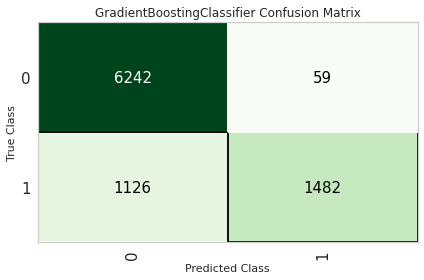

In [79]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

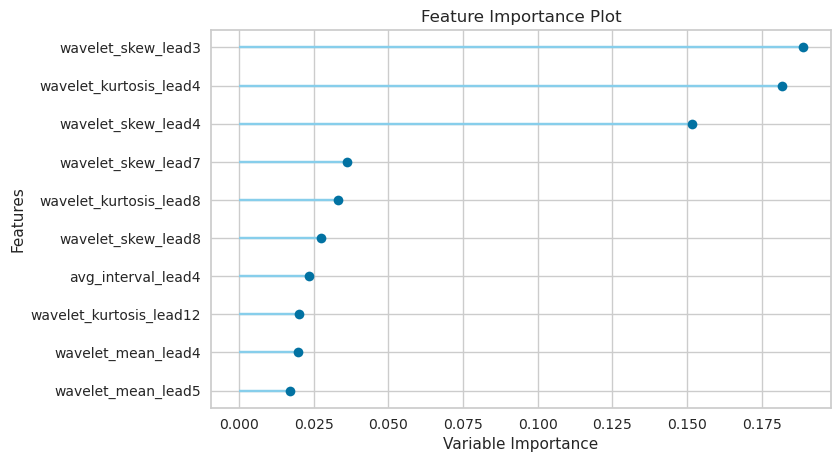

In [90]:
plot_model(gbc, plot = 'feature')

In [95]:
rf = create_model('rf')
rf_tuned = tune_model(rf, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7391,0.7676,0.4589,0.7035,0.5555,0.3822,0.3997
1,0.7256,0.7764,0.3729,0.7195,0.4913,0.3284,0.3616
2,0.7059,0.7282,0.3793,0.6466,0.4781,0.2922,0.3123
3,0.7405,0.7470,0.4716,0.6998,0.5634,0.3886,0.4039
4,0.7687,0.7600,0.5006,0.7674,0.6060,0.4524,0.4731
5,0.7803,0.8016,0.4861,0.8223,0.6110,0.4717,0.5033
6,0.7381,0.7670,0.3456,0.8053,0.4836,0.3437,0.3990
7,0.7547,0.7840,0.4753,0.7416,0.5794,0.4177,0.4383
8,0.7305,0.7481,0.4564,0.6798,0.5461,0.3648,0.3795


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7063,0.7437,0.3515,0.6635,0.4595,0.2832,0.3101
1,0.7454,0.7490,0.3982,0.7759,0.5263,0.3760,0.4151
2,0.7126,0.7105,0.3742,0.6712,0.4805,0.3034,0.3281
3,0.7432,0.7545,0.4046,0.7601,0.5281,0.3734,0.4085
4,0.7629,0.7779,0.4766,0.7678,0.5881,0.4342,0.4585
5,0.7664,0.7760,0.4418,0.8154,0.5731,0.4312,0.4696
6,0.7278,0.7597,0.3063,0.8067,0.4440,0.3091,0.3726
7,0.7471,0.7802,0.4513,0.7346,0.5591,0.3957,0.4187
8,0.7300,0.7471,0.4437,0.6855,0.5388,0.3600,0.3771


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
